(4400,)
[[23.19517653]
 [30.97070679]] 
and 
 [[22.92302384]
 [30.84321028]]


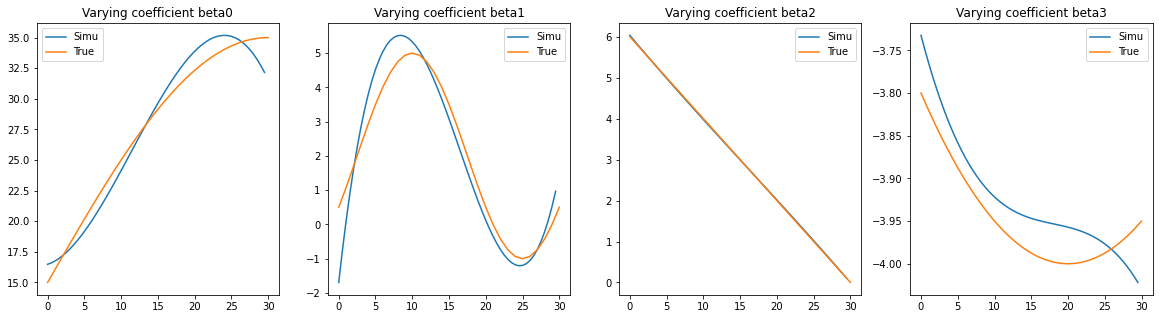

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as ss
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import time

## set self path
import sys
sys.path.append(r'/Desktop')

from sklearn.metrics import r2_score, mean_absolute_percentage_error,mean_squared_error,mean_absolute_error,median_absolute_error,mean_squared_log_error

from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')


## Define true coefficients

def beta_0(t):
    return (15+20*math.sin(t*math.pi/60))
    
def beta_1(t):
    return (2-3*math.cos((t-25)*math.pi/15))

def beta_2(t):
    return 6-0.2*t

def beta_3(t):
    return (-4+(20-t)*(20-t)/2000)

def y(t,x1,x2,x3,e):
    return beta_0(t) + beta_1(t)*x1 + beta_2(t)*x2 + beta_3(t)*x3 + e ## ?remove e

## Generate simulated data

def simu_t(x):
    seed = np.random.randint(0, 10000)
    t = np.arange(x,dtype = float)
    num_drop = int(0.3 * x)
    np.random.seed(seed)
#     np.random.seed(69)
    mask = np.random.choice(x,x-num_drop, replace=False)
    t_dropped = t[mask]
    t_dropped = np.sort(t_dropped)
    return t_dropped

simu_time = []
for i in range(200):
    t1 = simu_t(31)
    simu_time.append(t1)
    

simu_time = np.array(simu_time).reshape(-1,)


simu_e = []
for i in range(len(simu_time)):
    simu_e.append(np.random.normal(loc=0, scale=0.1))
    
simu_x1 = []
for i in range(len(simu_time)):
    simu_x1.append(np.random.uniform(simu_time[i]/10, 2+simu_time[i]/10))
simu_x1 = np.array(simu_x1).reshape(-1,)

simu_x2 = []
for i in range(len(simu_time)):
    simu_x2.append(np.random.normal(loc=0, scale=(1+simu_x1[i])/(2+simu_x1[i])))
simu_x2 = np.array(simu_x2).reshape(-1,)

simu_x3 = []
for i in range(len(simu_time)):
    simu_x3.append(np.random.choice([0, 1], p=[0.4, 0.6]))
simu_x3 = np.array(simu_x3).reshape(-1,)

y_true = []
for i in range(len(simu_time)):
    yi = y(simu_time[i],simu_x1[i],simu_x2[i],simu_x3[i],simu_e[i])
    # print(simu_time[i],simu_x1[i],simu_x2[i],simu_x3[i],simu_e[i])
    y_true.append(yi)
print(np.shape(y_true))

# y_true
y_true = np.array(y_true)
X = np.zeros((len(simu_time),5))
X[:,0] = simu_time
X[:,1] = np.ones((len(simu_time),))
X[:,2] = simu_x1
X[:,3] = simu_x2
X[:,4] = simu_x3    

def cubSplineEach(Xi,yi):
    tStep = Xi[:,0]
    Xi = Xi[:,1:]
    numFea = np.shape(Xi)[1]-1
    
    # B_t
    # U_i
    U_ij = np.zeros((4*(numFea+1),1))
    U_i = np.zeros((len(tStep),4*(numFea+1)))
    for j in range(len(tStep)):
        t = tStep[j]
        B_t = np.zeros((numFea+1, 4*(numFea+1)))
        for count in range(0,numFea+1):
            B_t[count][count*4:(count+1)*4] = [1, t, t**2, t**3] # cubic spline
        U_ij = ((Xi[j][:].reshape(1,-1))@B_t).transpose()
        for i in range(len(U_i[j][:])):
            U_i[j][i] = U_ij[i]  
        
    # W_i
    W_i = np.zeros((len(tStep),len(tStep)))
    for j in range(len(tStep)):
        W_i[j][j] = 1/len(tStep)

    return B_t, U_i, W_i

def cubSpineVCM(X,y,nStep,numFea):
    sum1 = np.zeros((4*(numFea+1),4*(numFea+1)))
    sum2 = np.zeros((4*(numFea+1),1))
    for i in range(int(len(y)/nStep)):
        Xi = X[i*nStep:(i+1)*nStep, :]
        yi = y[i*nStep:(i+1)*nStep]
        B_t, U_i, W_i = cubSplineEach(Xi,yi)
        sum1 = np.add(np.array(sum1), U_i.transpose()@W_i@U_i)
        sum2 = np.array(sum2)+ (U_i.transpose()@W_i@yi).reshape(-1,1)
        
    y_hat = np.zeros((4*(numFea+1),1))
    y_hat = np.linalg.pinv(sum1)@(sum2)

    # Beta 
    # Add leave one out cross validation
    beta = []
#     for t in range(nStep):
    maximum = np.max(X[:,0])
    for t in np.arange(0.0,maximum,0.5):
        beta_t = np.zeros((numFea+1,1))
        B_t = np.zeros((numFea+1, 4*(numFea+1)))
        for count in range(0,numFea+1):
            B_t[count][count*4:(count+1)*4] = [1, t, t**2, t**3]
        beta_t = B_t@y_hat
        beta.append(beta_t)
    return np.array(beta), y_hat, maximum


#beta_all, y_hat = cubSpineVCM(X,y,nStep,numFea)

def cubSpineVCM_fit(y_hat,X_te):
    numFea = np.shape(X_te)[1]-2
    prediction = []
    for obs in range(np.shape(X_te)[0]):
        t = X_te[obs][0]
        beta_t = np.zeros((numFea+1,1))
        B_t = np.zeros((numFea+1, 4*(numFea+1)))
        for count in range(0,numFea+1):
            B_t[count][count*4:(count+1)*4] = [1, t, t**2, t**3]
        beta_t = B_t@y_hat
        y_pred = 0
        for i in range(numFea+1):
            y_pred += beta_t[i]*X_te[obs][i+1]
        prediction.append(y_pred)
    return np.array(prediction)

# True coefficient
beta0 = []
beta1 = []
beta2 = []
beta3 = []
for i in range(31):
    beta0.append(beta_0(i))
    beta1.append(beta_1(i))
    beta2.append(beta_2(i))
    beta3.append(beta_3(i))

# Simulated coefficient
beta,gamma,maximum = cubSpineVCM(X,y_true,31,3)
X_te = np.array([[2.5, 1, 2, 3, 4],[9.3, 1, 2, 3, 4]]).reshape(2,-1)
y_te = np.array([y(2.5, 2, 3, 4, 0.2),y(9.3, 2, 3, 4, -0.1)]).reshape(-1,1)
y_pre = cubSpineVCM_fit(gamma,X_te)
print(y_pre,"\nand \n", y_te)


plt.figure(figsize = (20,5))    
plt.subplot(1,4,1)
plt.plot(np.arange(0,maximum,0.5), beta[:,0],label = "Simu")
plt.plot(np.arange(0,31,1), np.array(beta0),label = "True")
plt.title("Varying coefficient beta0")
plt.legend()

plt.subplot(1,4,2)
plt.plot(np.arange(0,maximum,0.5),beta[:,1],label = "Simu")
plt.plot(np.arange(0,31,1),np.array(beta1),label = "True")
plt.title("Varying coefficient beta1")
plt.legend()

plt.subplot(1,4,3)
plt.plot(np.arange(0,maximum,0.5),beta[:,2],label = "Simu")
plt.plot(np.arange(0,31,1),np.array(beta2),label = "True")
plt.title("Varying coefficient beta2")
plt.legend()

plt.subplot(1,4,4)
plt.plot(np.arange(0,maximum,0.5),beta[:,3],label = "Simu")
plt.plot(np.arange(0,31,1),np.array(beta3),label = "True")
plt.title("Varying coefficient beta3")
plt.legend()

plt.show()

In [4]:
def metrics(Y_pre,Y_te):
    n = len(Y_te)
    Y_pre = 0.001*Y_pre
    Y_te = 0.001*Y_te
    MSE = mean_squared_error(Y_te,Y_pre)
    MAE = mean_absolute_error(Y_te,Y_pre)
#     MSLE = mean_squared_log_error(Y_te,Y_pre)
    MSLE = (np.sum(np.log((Y_pre+1)/(Y_te+1)))**2)/n
#     R_squared = r2_score(Y_te,Y_pre)
    MAPE =mean_absolute_percentage_error(Y_te,Y_pre)
    MedianAE = median_absolute_error(Y_te,Y_pre)
    return MSE,MAE,MSLE,MAPE,MedianAE


data_all = pd.read_csv(r'/Users/danleizhu/Desktop/simulatedcashflows.csv')

data=data_all[(data_all['AY']==1994)]
data["sum"]=data[["Pay00","Pay01","Pay02","Pay03","Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay00"]+x["Pay01"]+x["Pay02"]+x["Pay03"]+x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year1"]=data[["Pay01","Pay02","Pay03","Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay01"]+x["Pay02"]+x["Pay03"]+x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year2"]=data[["Pay02","Pay03","Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay02"]+x["Pay03"]+x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year3"]=data[["Pay03","Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay03"]+x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year4"]=data[["Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year5"]=data[["Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year6"]=data[["Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year7"]=data[["Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year8"]=data[["Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year9"]=data[["Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year10"]=data[["Pay10","Pay11"]].apply(lambda x:x["Pay10"]+x["Pay11"],axis=1)
data["year11"]=data[["Pay11"]].apply(lambda x:x["Pay11"],axis=1)

data["year1_before"] = data[["sum","year1"]].apply(lambda x:x["sum"]- x["year1"],axis=1)
data["year2_before"] = data[["sum","year2"]].apply(lambda x:x["sum"]- x["year2"],axis=1)
data["year3_before"] = data[["sum","year3"]].apply(lambda x:x["sum"]- x["year3"],axis=1)
data["year4_before"] = data[["sum","year4"]].apply(lambda x:x["sum"]- x["year4"],axis=1)
data["year5_before"] = data[["sum","year5"]].apply(lambda x:x["sum"]- x["year5"],axis=1)
data["year6_before"] = data[["sum","year6"]].apply(lambda x:x["sum"]- x["year6"],axis=1)
data["year7_before"] = data[["sum","year7"]].apply(lambda x:x["sum"]- x["year7"],axis=1)
data["year8_before"] = data[["sum","year8"]].apply(lambda x:x["sum"]- x["year8"],axis=1)
data["year9_before"] = data[["sum","year9"]].apply(lambda x:x["sum"]- x["year9"],axis=1)
data["year10_before"] = data[["sum","year10"]].apply(lambda x:x["sum"]- x["year10"],axis=1)
data["year11_before"] = data[["sum","year11"]].apply(lambda x:x["sum"]- x["year11"],axis=1)

pay_year = np.array(data[["Pay00","Pay01","Pay02","Pay03","Pay04","Pay05","Pay06",
                          "Pay07","Pay08","Pay09","Pay10","Pay11"]])

data_year = np.array(data[["sum","year1","year2","year3","year4","year5","year6"
                           ,"year7","year8","year9","year10","year11"]])
data_before_year = np.array(data[["year1_before","year2_before","year3_before",
                                  "year4_before","year5_before","year6_before"
                           ,"year7_before","year8_before","year9_before","year10_before","year11_before"]])

data_before_year = np.column_stack(((np.zeros(data_before_year.shape[0]),data_before_year)))

## Transformation
data[['age']] = np.log(data[['age']])
data[['inj_part']] = np.sqrt(data[['inj_part']])

pay_year = preprocessing.normalize(pay_year)

************** The number of features: 6 *************


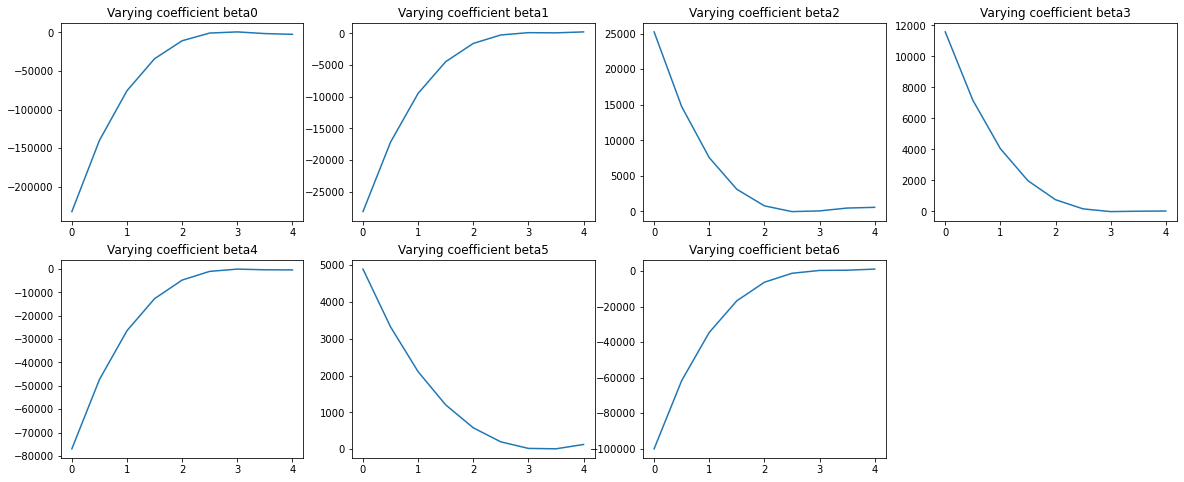

************** The number of features: 7 *************


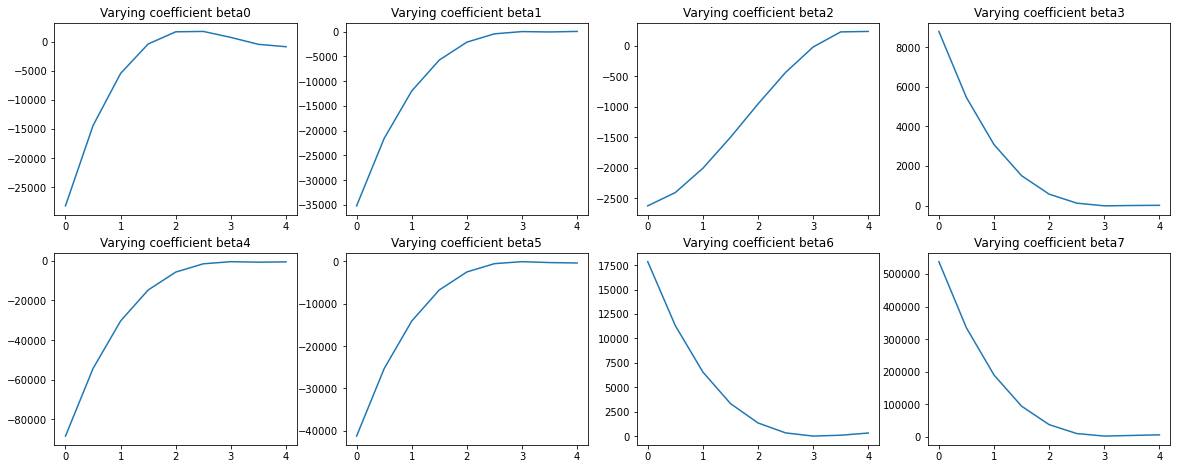

************** The number of features: 8 *************


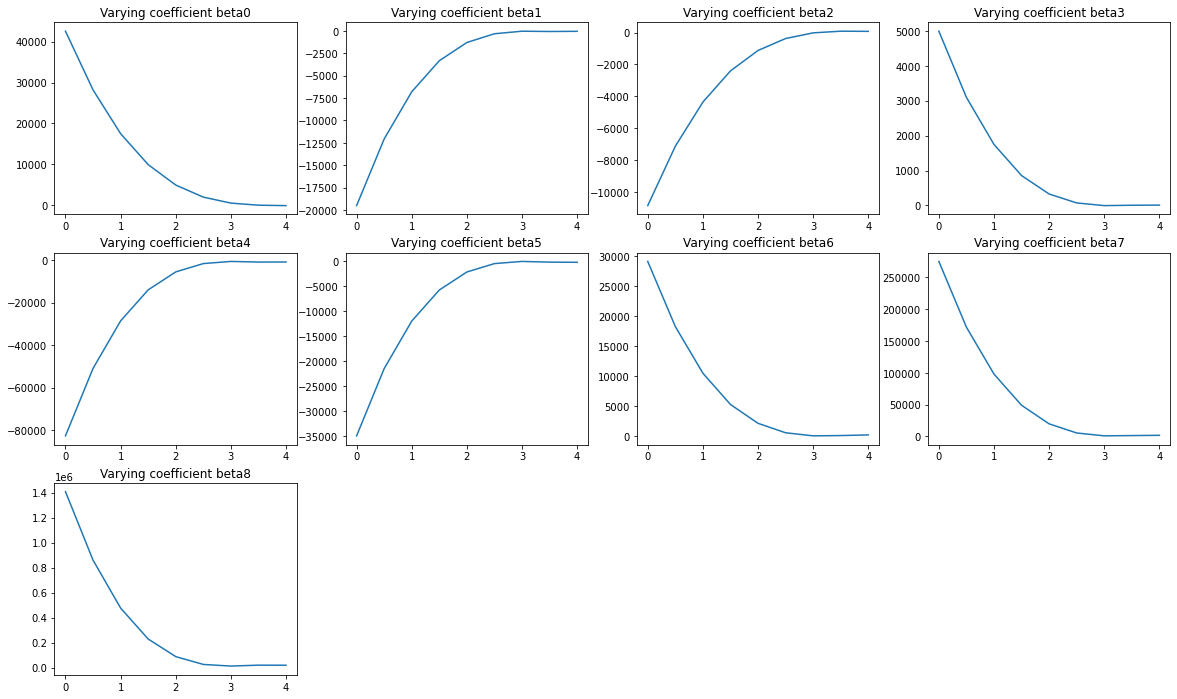

************** The number of features: 9 *************


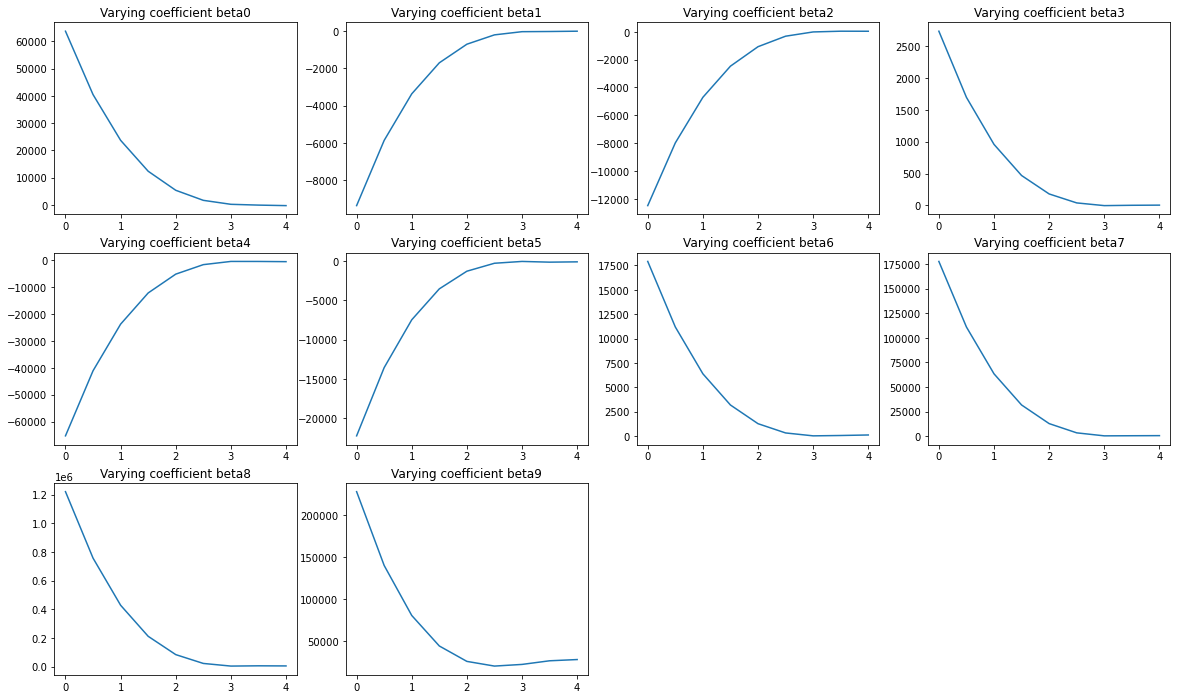

************** The number of features: 10 *************


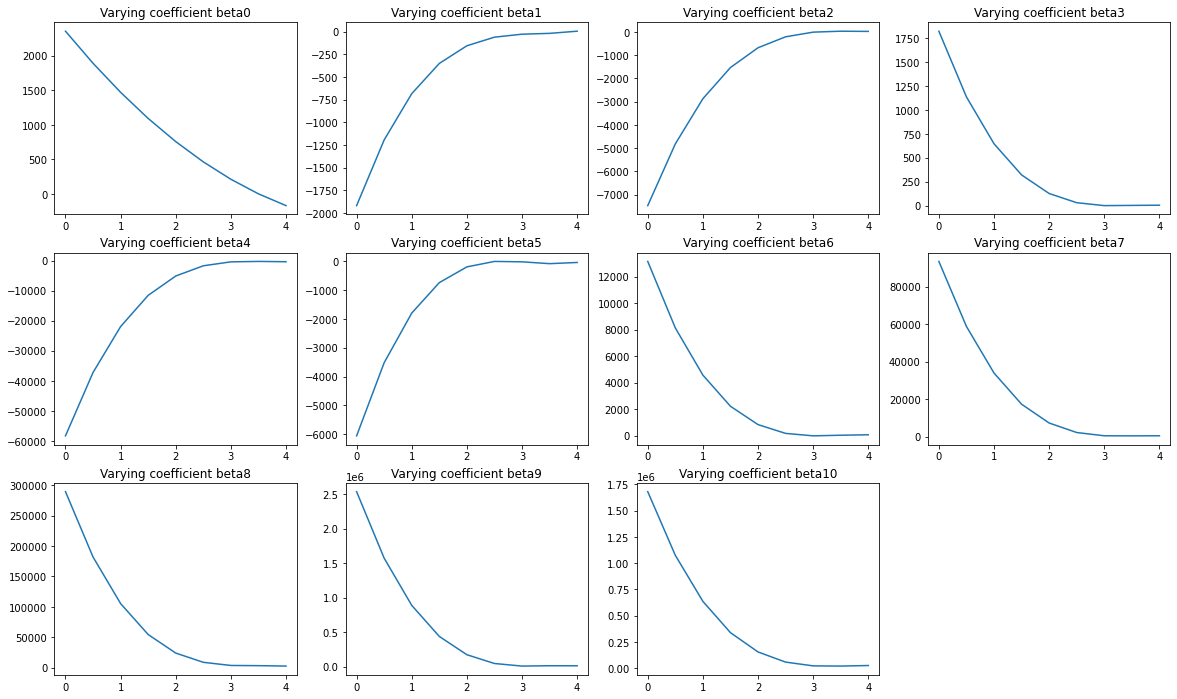

************** The number of features: 11 *************


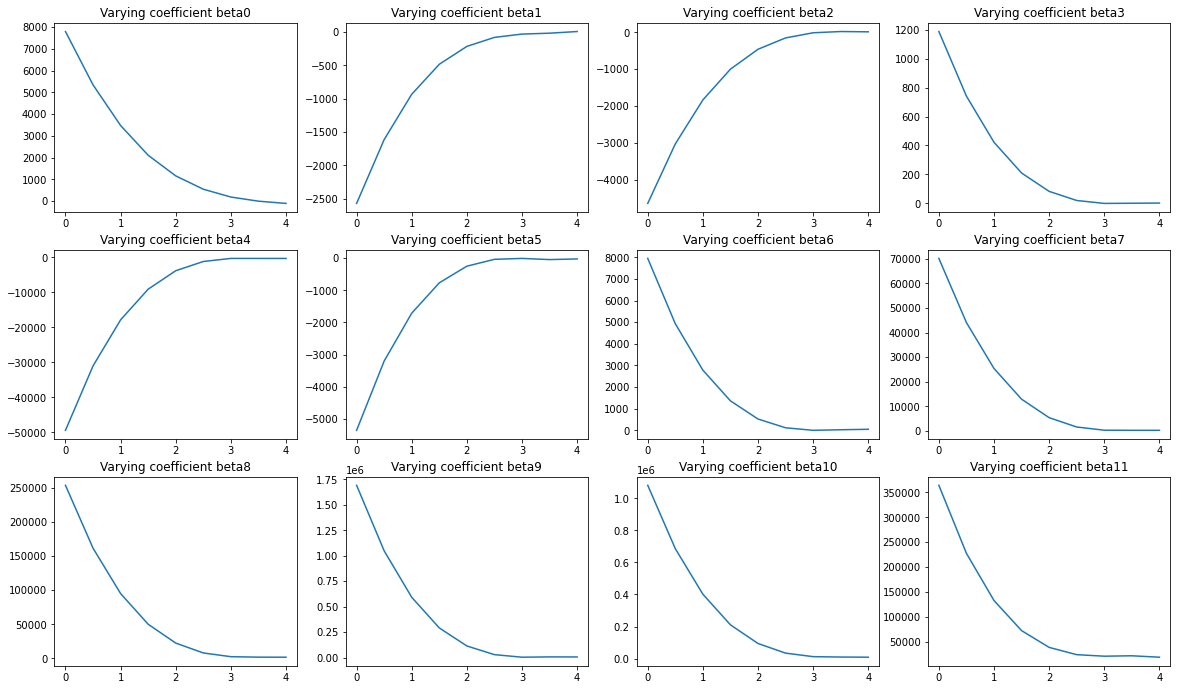

************** The number of features: 12 *************


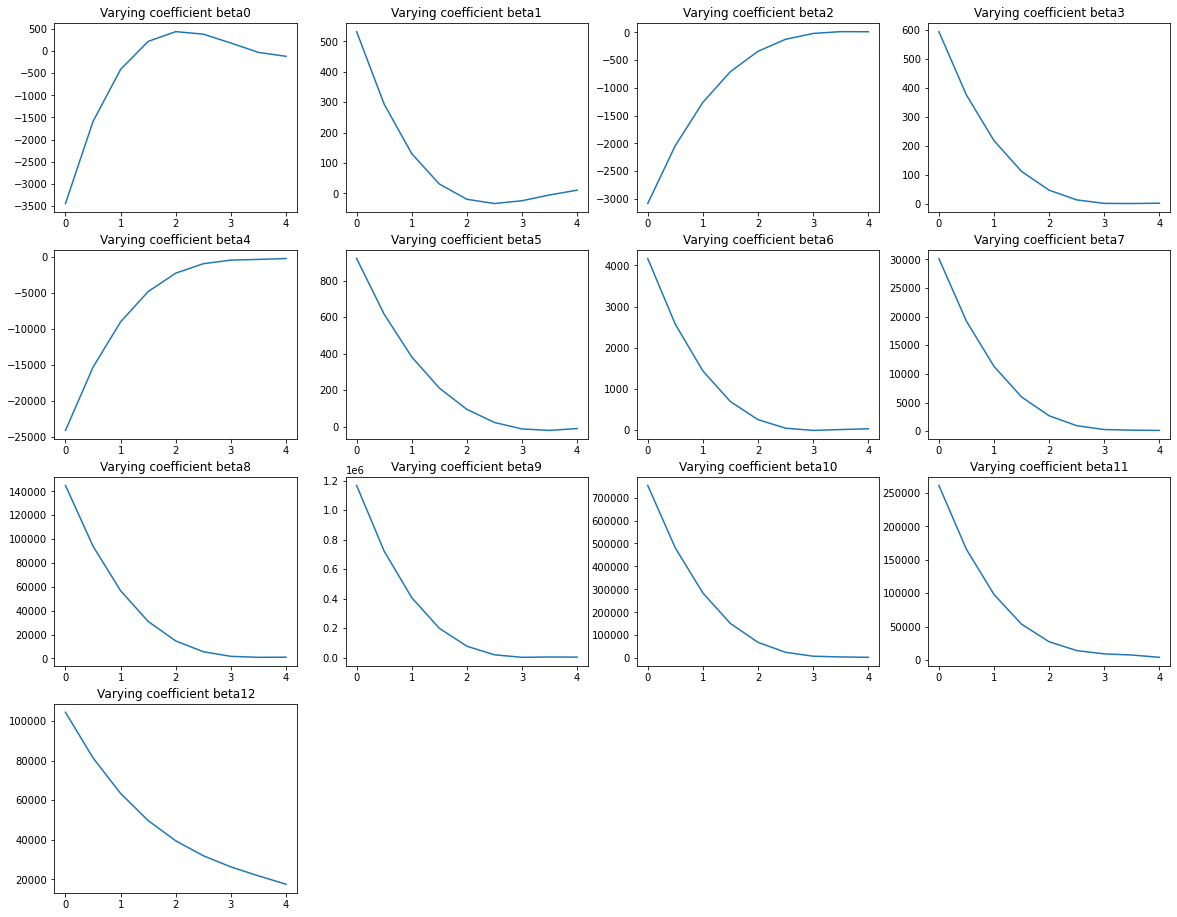

************** The number of features: 13 *************


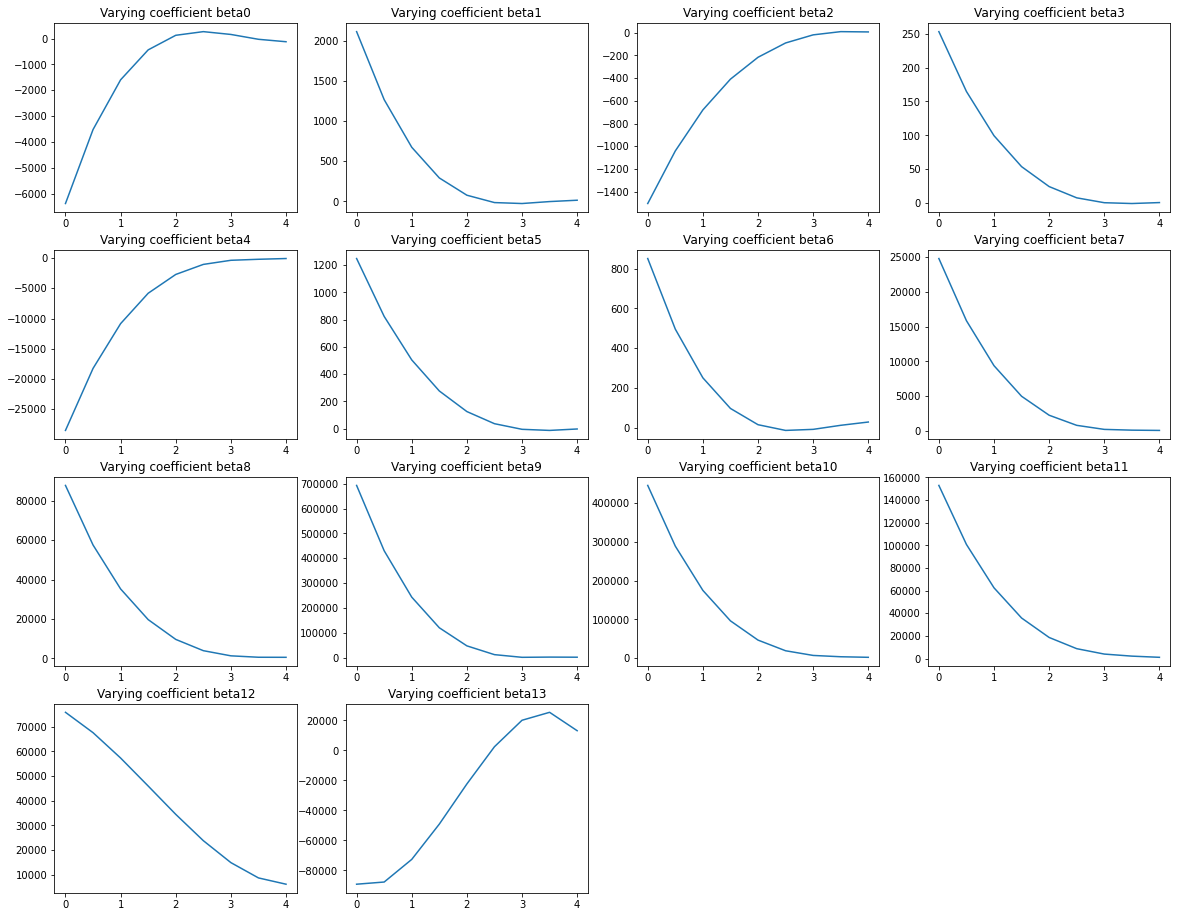

************** The number of features: 14 *************


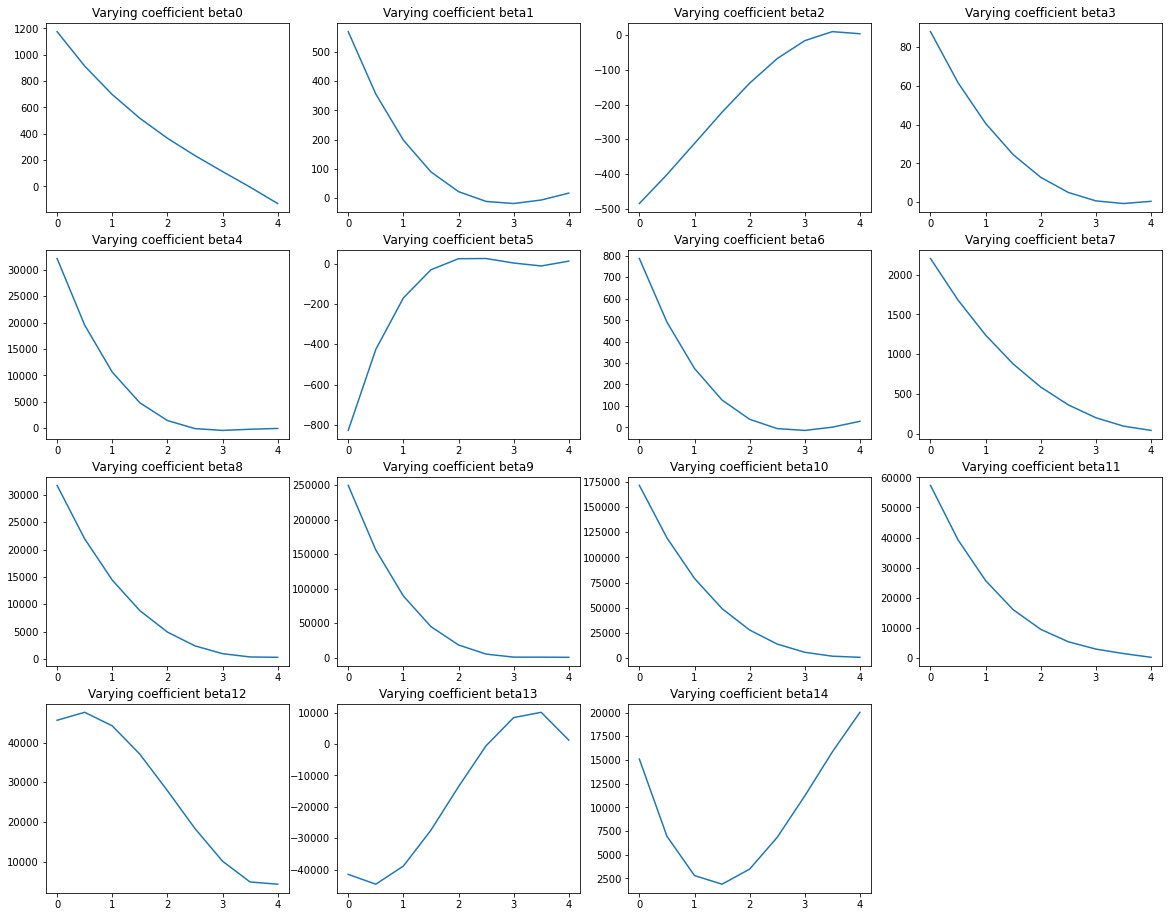

************** The number of features: 15 *************


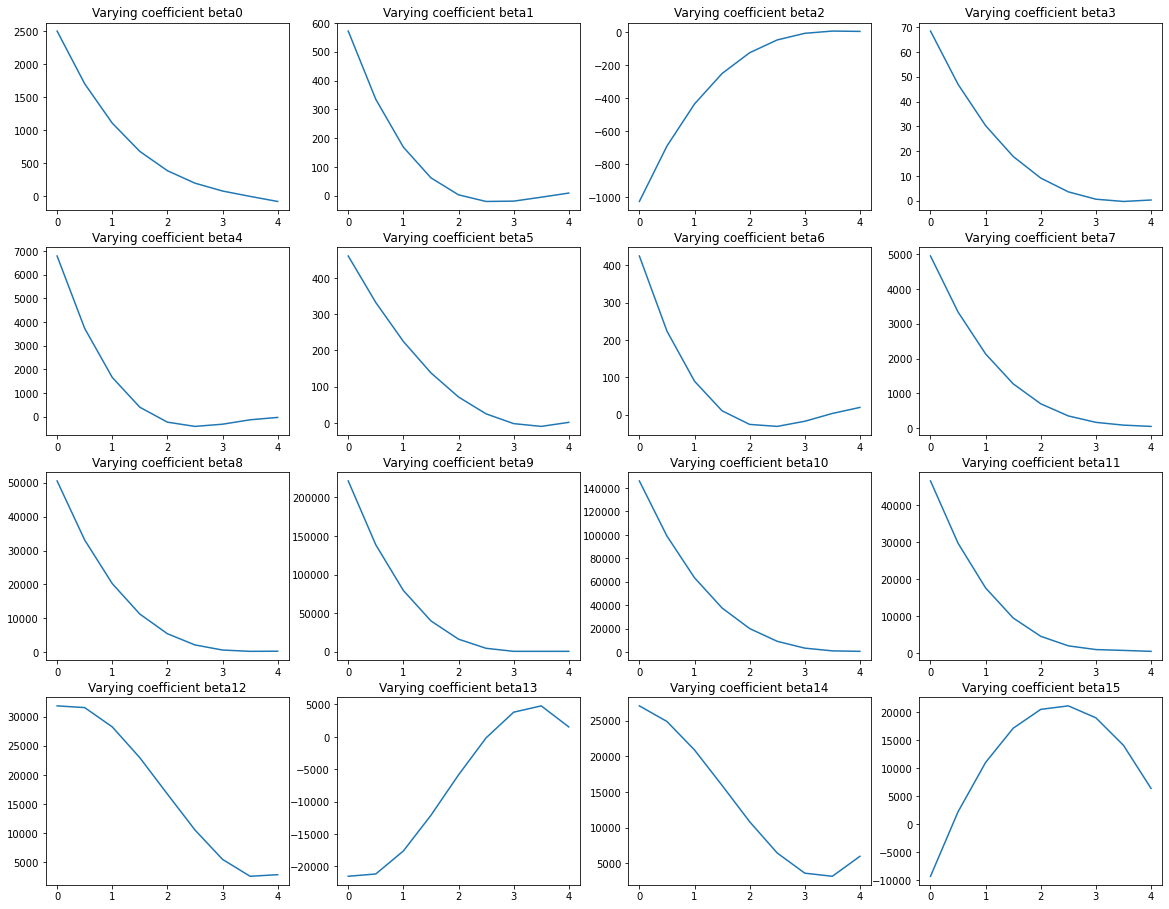

************** The number of features: 16 *************


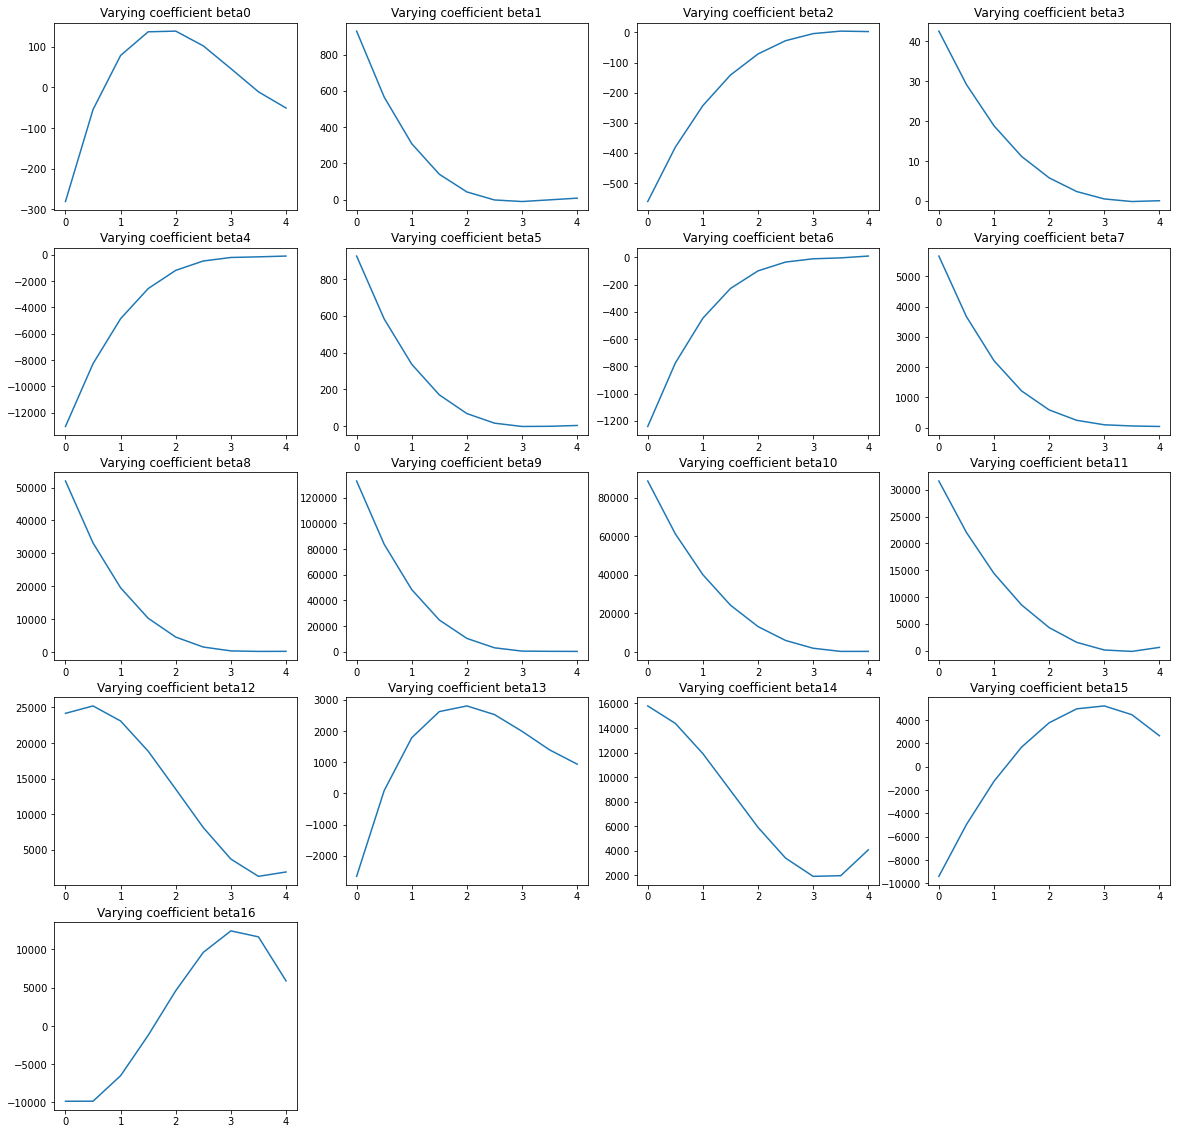

************** The number of features: 17 *************


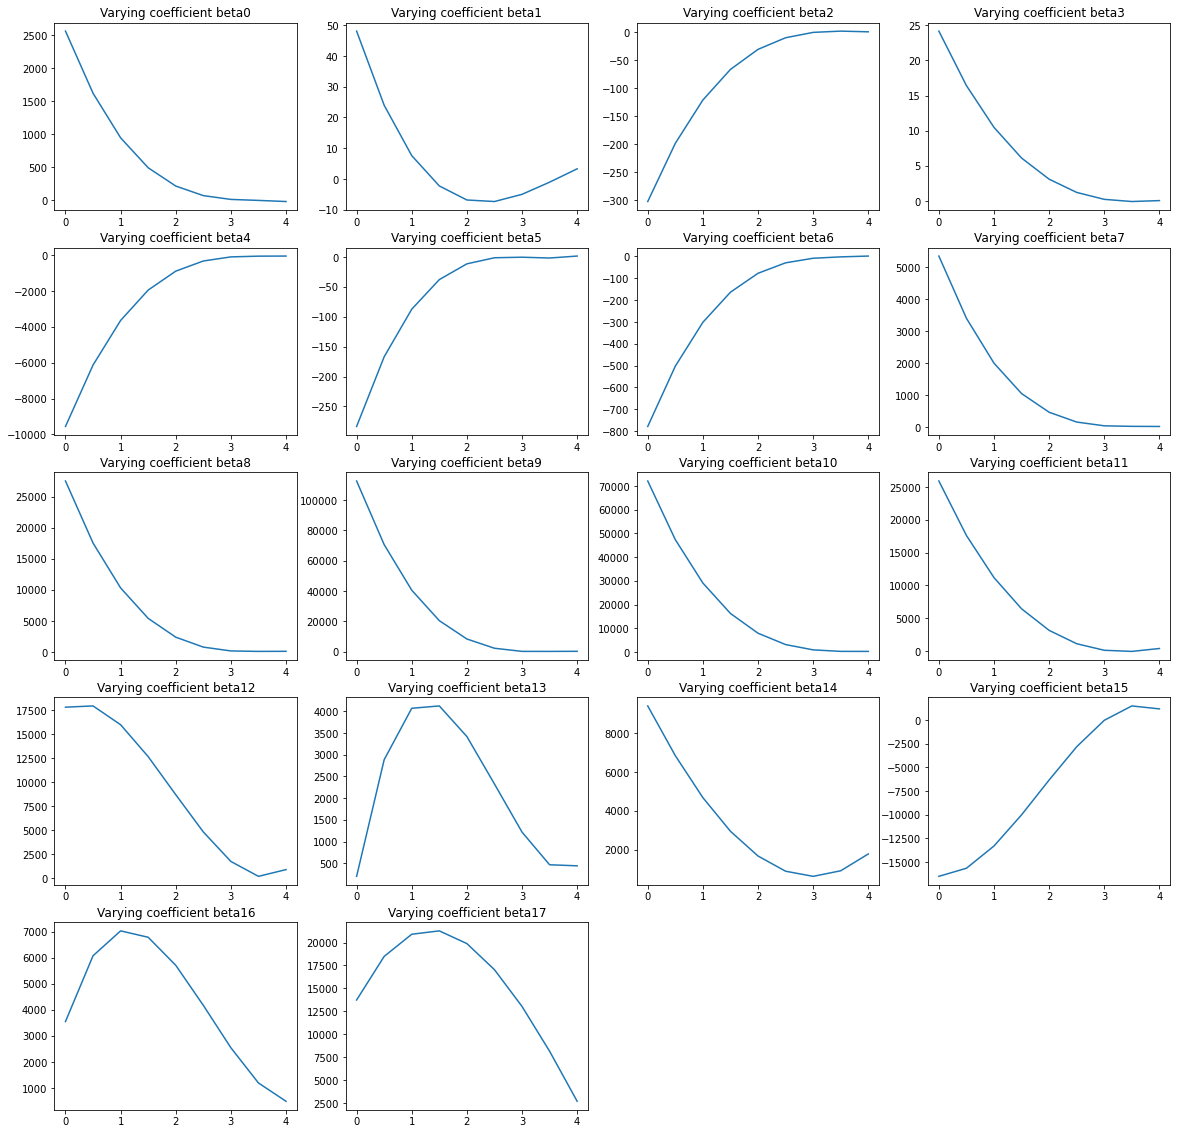

In [11]:
kfold = 5
def cross_val_cubicVCM(X,y,kfold):
    kf = KFold(n_splits=kfold, shuffle = True, random_state = 0)
    j = int(0)
    numfeature = X.shape[1]-2
    matrics_record = np.zeros((5,7))
    matrics_mean = np.zeros(7)
    count = 0
    for train_index , test_index in kf.split(X): 
        N = len(train_index)
        n = len(test_index)
        X_tr = np.zeros((N,numfeature+2))
        y_tr = np.zeros(N)
        X_te = np.zeros((n,numfeature+2))
        y_te = np.zeros(n)
        
        for i in range(N):
            X_tr[i] = X[train_index[i]]
            y_tr[i] = y[train_index[i]]
        for i in range(n):
            X_te[i] = X[test_index[i]]
            y_te[i] = y[test_index[i]]
            
        start1 = time.time()
        beta,gamma,maxNum = cubSpineVCM(X_tr,y_tr,1,numfeature)
#         print(np.shape(beta))
        end1 = time.time()
        runtime1 = end1 - start1
        
        start2 = time.time()
        y_pre = cubSpineVCM_fit(gamma,X_te)
        end2 = time.time()
        runtime2 = end2 - start2
        
        matrics_record[count,0:-2] = metrics(y_pre,y_te)
        matrics_record[count,-2] = runtime1
        matrics_record[count,-1] = runtime2 
        count += 1
    print("************** The number of features:", numfeature,"*************")
    rows = int((numfeature+1)/4)+1
    plt.figure(figsize = (20,rows*4))
    for i in range(numfeature+1):
        plt.subplot(rows,4,i+1)
        plt.plot(np.arange(0,maxNum,0.5), beta[:,i])
        plt.title(f"Varying coefficient beta%d" % i)
    plt.show()
    
    for i in range(7):
        matrics_mean[i] = np.mean(matrics_record[:,i])
        
    return matrics_mean

metrics_grid_cubicSpline = np.zeros((12,7))
for i in range(12):
    X = np.array(data[['LoB','inj_part','cc','RepDel','AQ']])
    X = np.column_stack((np.ones(len(X)), X))
    X = np.column_stack((np.array(data[['age']]), X))
    X = np.column_stack((X, (pay_year[:,0:i+1])))
#     X = X.values
    y = data_year[:,i]
    N = len(y)
    metrics_grid_cubicSpline[i,:] = cross_val_cubicVCM(X,y,kfold)
    


In [4]:
metrics_grid_cubicSpline

array([[3.76773433e+02, 2.41779257e+00,            nan, 1.73588403e+15,
        1.24886396e+00, 1.45368195e+00, 3.20835972e-01],
       [2.19469382e+02, 1.54001769e+00,            nan, 1.71796587e+15,
        5.05916756e-01, 1.54725633e+00, 3.56973124e-01],
       [8.68958773e+01, 8.34852686e-01,            nan, 1.49183320e+15,
        2.32741008e-01, 1.68439808e+00, 3.98434830e-01],
       [3.97002685e+01, 5.23666190e-01,            nan, 1.06250878e+15,
        1.25703724e-01, 1.82984543e+00, 4.44079781e-01],
       [2.00230776e+01, 3.61969639e-01,            nan, 7.72912871e+14,
        7.78337756e-02, 1.97242179e+00, 4.80085707e-01],
       [1.02632419e+01, 2.74118693e-01,            nan, 6.20206496e+14,
        5.48710661e-02, 2.10134754e+00, 5.15688896e-01],
       [4.94792850e+00, 1.96566934e-01,            nan, 4.54838376e+14,
        3.49225851e-02, 2.27226534e+00, 5.61756706e-01],
       [2.54245973e+00, 1.44518331e-01,            nan, 3.49340505e+14,
        2.82126292e-02, 2

In [5]:


metrics_grid_cubicSpline1 = np.zeros((12,7))
metrics_grid_cubicSpline2 = np.zeros((12,7))
metrics_grid_cubicSpline3 = np.zeros((12,7))
metrics_grid_cubicSpline4 = np.zeros((12,7))
metrics_grid_cubicSpline5 = np.zeros((12,7))

for i in range(12):
    X = np.array(data[['age','inj_part','cc','RepDel','AQ']])
    X = np.column_stack((np.ones(len(X)), X))
    X = np.column_stack((np.array(data[['LoB']]), X))
    X = np.column_stack((X, (pay_year[:,0:i+1])))
#     X = X.values
    y = data_year[:,i]
    N = len(y)
    metrics_grid_cubicSpline1[i,:] = cross_val_cubicVCM(X,y,kfold)
    
for i in range(12):
    X = np.array(data[['age','LoB','cc','RepDel','AQ']])
    X = np.column_stack((np.ones(len(X)), X))
    X = np.column_stack((np.array(data[['inj_part']]), X))
    X = np.column_stack((X, (pay_year[:,0:i+1])))
#     X = X.values
    y = data_year[:,i]
    N = len(y)
    metrics_grid_cubicSpline2[i,:] = cross_val_cubicVCM(X,y,kfold)
    
for i in range(12):
    X = np.array(data[['age','inj_part','LoB','RepDel','AQ']])
    X = np.column_stack((np.ones(len(X)), X))
    X = np.column_stack((np.array(data[['cc']]), X))
    X = np.column_stack((X, (pay_year[:,0:i+1])))
#     X = X.values
    y = data_year[:,i]
    N = len(y)
    metrics_grid_cubicSpline3[i,:] = cross_val_cubicVCM(X,y,kfold)
    
for i in range(12):
    X = np.array(data[['age','inj_part','cc','LoB','AQ']])
    X = np.column_stack((np.ones(len(X)), X))
    X = np.column_stack((np.array(data[['RepDel']]), X))
    X = np.column_stack((X, (pay_year[:,0:i+1])))
#     X = X.values
    y = data_year[:,i]
    N = len(y)
    metrics_grid_cubicSpline4[i,:] = cross_val_cubicVCM(X,y,kfold)
    
for i in range(12):
    X = np.array(data[['age','inj_part','cc','RepDel','LoB']])
    X = np.column_stack((np.ones(len(X)), X))
    X = np.column_stack((np.array(data[['AQ']]), X))
    X = np.column_stack((X, (pay_year[:,0:i+1])))
#     X = X.values
    y = data_year[:,i]
    N = len(y)
    metrics_grid_cubicSpline5[i,:] = cross_val_cubicVCM(X,y,kfold)

************** The number of features: 6 *************
************** The number of features: 7 *************
************** The number of features: 8 *************
************** The number of features: 9 *************
************** The number of features: 10 *************
************** The number of features: 11 *************
************** The number of features: 12 *************
************** The number of features: 13 *************
************** The number of features: 14 *************
************** The number of features: 15 *************
************** The number of features: 16 *************
************** The number of features: 17 *************
************** The number of features: 6 *************
************** The number of features: 7 *************
************** The number of features: 8 *************
************** The number of features: 9 *************
************** The number of features: 10 *************
************** The number of features: 11 *************


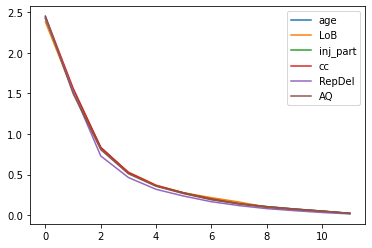

In [12]:
# print(metrics_grid_cubicSpline1[:,0])
# print(metrics_grid_cubicSpline2[:,0])
# print(metrics_grid_cubicSpline3[:,0])
# print(metrics_grid_cubicSpline4[:,0])
# print(metrics_grid_cubicSpline5[:,0])

plt.plot(metrics_grid_cubicSpline[:,1],label = 'age')
plt.plot(metrics_grid_cubicSpline1[:,1],label = 'LoB')
plt.plot(metrics_grid_cubicSpline2[:,1],label ='inj_part')
plt.plot(metrics_grid_cubicSpline3[:,1],label ='cc')
plt.plot(metrics_grid_cubicSpline4[:,1],label ='RepDel')
plt.plot(metrics_grid_cubicSpline5[:,1],label ='AQ')
plt.legend()
plt.show()



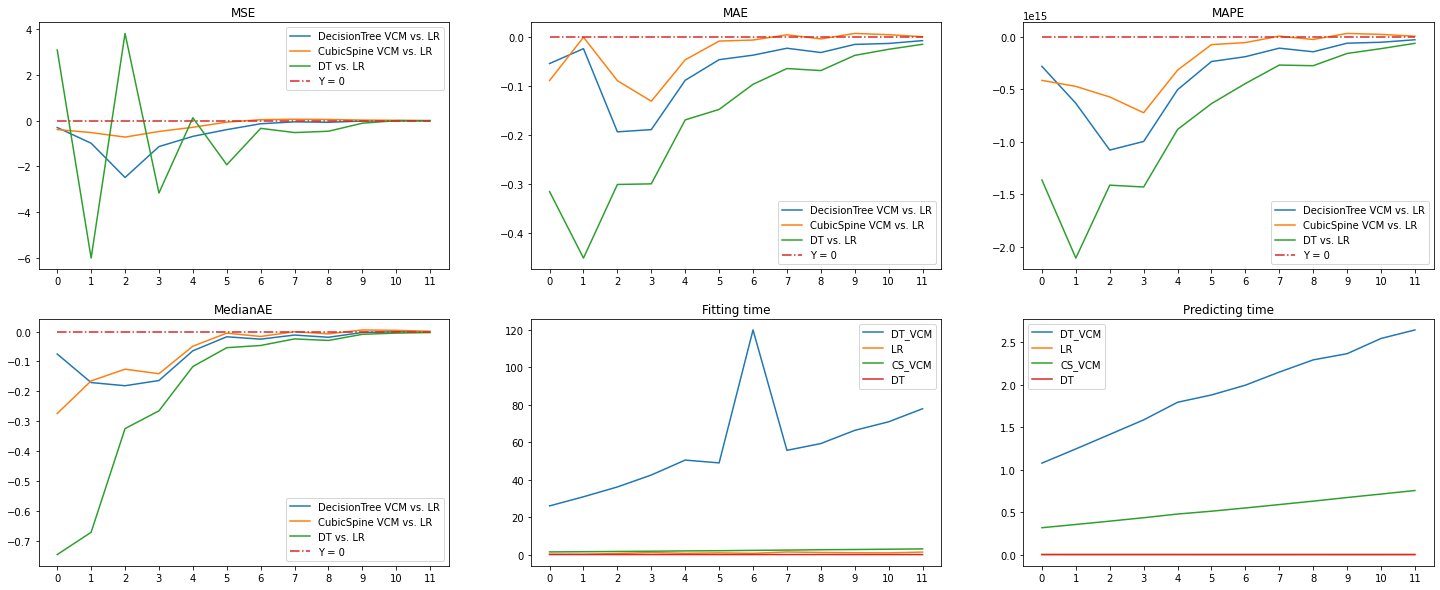

In [33]:

## dtVCM
metrics_grid_dtVCM = np.array([[3.76862363e+02, 2.45258691e+00,"nan", 1.86869770e+15,
  1.44754095e+00, 2.59858362e+01, 1.07803321e+00],
 [2.19004811e+02, 1.51663536e+00,           "nan", 1.55726474e+15,
  5.00435418e-01,3.08574214e+01, 1.24549880e+00],
 [8.51328775e+01, 7.30194564e-01,            "nan", 9.87257278e+14,
  1.77437742e-01, 3.61001847e+01, 1.41629834e+00],
 [3.90406362e+01, 4.65584158e-01,            "nan", 7.89693277e+14,
  1.02997134e-01, 4.24769947e+01, 1.58770700e+00],
 [1.96270216e+01, 3.20092270e-01,            "nan", 5.86703533e+14,
  6.25432842e-02, 5.04411652e+01, 1.79538832e+00],
 [9.93637462e+00, 2.36081452e-01,            "nan", 4.59616109e+14,
  4.27830327e-02, 4.89381702e+01, 1.88157797e+00],
 [4.76967445e+00, 1.65638379e-01,            "nan", 3.20778183e+14,
  2.59683325e-02, 1.19906919e+02, 1.99691191e+00],
 [2.42979928e+00, 1.17023864e-01,            "nan", 2.35123416e+14,
  1.70716528e-02, 5.56457367e+01, 2.15122223e+00],
 [1.29958874e+00, 7.92384087e-02,            "nan", 1.53876688e+14,
  1.10059372e-02, 5.92660913e+01, 2.29508719e+00],
 [6.28515203e-01, 5.51602678e-02,            "nan", 1.28028661e+14,
  8.03228669e-03, 6.63064127e+01, 2.36813064e+00],
 [2.56437469e-01, 3.33073416e-02,            "nan", 8.09991204e+13,
  4.87048019e-03, 7.08891519e+01, 2.54745784e+00],
 [5.82712981e-02, 1.51507482e-02,            "nan", 3.85689746e+13,
  2.50994633e-03, 7.78482016e+01, 2.64802837e+00]],dtype = "object")

## lr
metrics_grid_lr = np.array([[3.77163693e+02, 2.50646100e+00, 2.52557807e+03, 2.15217523e+15,
  1.52262800e+00, 1.89177000e-01, 3.48000000e-04],
 [2.19992086e+02, 1.54005000e+00,            "nan", 2.19151838e+15,
  6.70799000e-01, 2.04695000e-01, 7.30000000e-05],
 [8.76150510e+01, 9.23753000e-01,            "nan", 2.06575896e+15,
  3.58398000e-01, 5.64365000e-01, 5.40000000e-05],
 [4.01741050e+01, 6.54589000e-01,            "nan", 1.78631116e+15,
  2.66571000e-01, 1.09560500e+00, 5.10000000e-05],
 [2.03142870e+01, 4.08180000e-01,            "nan", 1.09166638e+15,
  1.26803000e-01, 6.84507000e-01, 1.07000000e-04],
 [1.03305110e+01, 2.82018000e-01,            "nan", 6.96870287e+14,
  6.02860000e-02, 9.19353000e-01, 6.70000000e-05],
 [4.90741400e+00, 2.02344000e-01,            "nan", 5.12168228e+14,
  5.14010000e-02, 6.61451000e-01, 8.50000000e-05],
 [2.48346100e+00, 1.39563000e-01,            "nan", 3.45415275e+14,
  2.88030000e-02, 1.39222400e+00, 8.90000000e-05],
 [1.37250600e+00, 1.10562000e-01,            "nan", 2.98641506e+14,
  3.01980000e-02, 1.12846400e+00, 7.30000000e-05],
 [6.48615000e-01, 6.98570000e-02,            "nan", 1.91053050e+14,
  1.10810000e-02, 9.86093000e-01, 7.60000000e-05],
 [2.68452000e-01, 4.60610000e-02,            "nan", 1.35249488e+14,
  5.73900000e-03, 9.12773000e-01, 8.70000000e-05],
 [6.02050000e-02, 2.20970000e-02,            "nan", 6.90838766e+13,
  3.40300000e-03,1.33350400e+00, 7.40000000e-05]],dtype = "object")

# Decision tree
metrics_grid_dt = np.array([[3.80242856e+02, 2.19065992e+00 ,6.76644519e+02, 7.89253657e+14,
  7.77867577e-01, 1.30774498e-02, 4.66775894e-04],
 [2.13996584e+02, 1.08832460e+00,            'nan', 8.71373711e+13,
  4.45646977e-04, 1.19116306e-02, 4.37879562e-04],
 [9.14168973e+01, 6.22551447e-01,            'nan', 6.53867078e+14,
  3.42657294e-02, 1.19210243e-02, 4.19616699e-04],
 [3.70155273e+01, 3.54662022e-01,            'nan', 3.57053456e+14,
  1.76857176e-03, 1.41947746e-02, 4.35972214e-04],
 [2.04368828e+01, 2.39060143e-01,            'nan', 2.09106143e+14,
  9.90880949e-03, 1.46808147e-02, 3.40366364e-04],
 [8.40513690e+00, 1.34315082e-01,            'nan', 5.97727106e+13,
  6.33410387e-03, 9.85550880e-03, 2.46334076e-04],
 [4.56925966e+00, 1.06025684e-01,            'nan', 6.55709766e+13,
  4.86075687e-03, 1.32618427e-02, 2.64739990e-04],
 [1.96158070e+00, 7.55001464e-02,            'nan', 7.45760886e+13,
  4.20620365e-03, 1.29999638e-02, 2.80904770e-04],
 [9.08621436e-01, 4.23419463e-02,            'nan', 2.17584400e+13,
  4.46395447e-04, 9.46354866e-03, 3.55291367e-04],
 [5.35231201e-01, 3.27049621e-02,            'nan', 3.04747779e+13,
  1.87177694e-03, 1.25108242e-02, 2.82526016e-04],
 [2.66565443e-01, 2.13670832e-02,            'nan', 2.04585613e+13,
  5.91884949e-04, 1.20943069e-02, 3.18288803e-04],
 [5.32595499e-02, 7.64104185e-03,            'nan', 4.77299322e+12,
  0.00000000e+00, 8.48059654e-03, 3.51905823e-04]],dtype = "object")

plt.figure(figsize = (25,10))
diff1 = np.zeros((12,7))
diff2 = np.zeros((12,7))
diff3 = np.zeros((12,7))

name_year = ['0','1','2','3','4','5','6','7','8','9','10','11']
for i in range(7):
    if i!=2:
        diff1[:,i] =metrics_grid_dtVCM[:,i] - metrics_grid_lr[:,i]
        diff2[:,i] =metrics_grid_cubicSpline[:,i] - metrics_grid_lr[:,i]
        diff3[:,i] =metrics_grid_dt[:,i] - metrics_grid_lr[:,i]
historical = np.zeros(12)
plt.subplot(2,3,1)
plt.plot(name_year,diff1[:,0],label = "DecisionTree VCM vs. LR")
plt.plot(name_year,diff2[:,0],label = "CubicSpine VCM vs. LR")
plt.plot(name_year,diff3[:,0],label = "DT vs. LR")

plt.plot(name_year, historical,"-.",label = "Y = 0")
plt.title("MSE")
plt.legend()

plt.subplot(2,3,2)
plt.plot(name_year,diff1[:,1],label = "DecisionTree VCM vs. LR")
plt.plot(name_year,diff2[:,1],label = "CubicSpine VCM vs. LR")
plt.plot(name_year,diff3[:,1],label = "DT vs. LR")


plt.plot(name_year, historical,"-.",label = "Y = 0")
plt.title("MAE")

plt.legend()

plt.subplot(2,3,3)
plt.plot(name_year,diff1[:,3],label = "DecisionTree VCM vs. LR")
plt.plot(name_year,diff2[:,3],label = "CubicSpine VCM vs. LR")
plt.plot(name_year,diff3[:,3],label = "DT vs. LR")

plt.plot(name_year, historical,"-.",label = "Y = 0")
plt.legend()
plt.title("MAPE")


plt.subplot(2,3,4)
plt.plot(name_year,diff1[:,4],label = "DecisionTree VCM vs. LR")
plt.plot(name_year,diff2[:,4],label = "CubicSpine VCM vs. LR")
plt.plot(name_year,diff3[:,4],label = "DT vs. LR")

plt.plot(name_year, historical,"-.",label = "Y = 0")
plt.title("\nMedianAE")

plt.legend()

plt.subplot(2,3,5)
# plt.plot(name_year,diff1[:,5],label = "VC vs. DT")
# plt.plot(name_year,diff2[:,5],label = "VC vs. LR")
# plt.plot(name_year,diff3[:,5],label = "VC vs. Huber")
plt.plot(name_year,metrics_grid_dtVCM[:,5],label = "DT_VCM")
plt.plot(name_year,metrics_grid_lr[:,5],label = "LR")
plt.plot(name_year,metrics_grid_cubicSpline[:,5],label = "CS_VCM")
plt.plot(name_year,metrics_grid_dt[:,5],label = "DT")


plt.title("Fitting time")
plt.legend()

plt.subplot(2,3,6)
plt.plot(name_year,metrics_grid_dtVCM[:,6],label = "DT_VCM")
plt.plot(name_year,metrics_grid_lr[:,6],label = "LR")
plt.plot(name_year,metrics_grid_cubicSpline[:,6],label = "CS_VCM")
plt.plot(name_year,metrics_grid_dt[:,6],label = "DT")

plt.title("Predicting time")

plt.legend()
plt.show()

In [15]:
data_t=data_all[(data_all['AY']==1995)]

data_t["sum"]=data_t[["Pay00","Pay01","Pay02","Pay03","Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay00"]+x["Pay01"]+x["Pay02"]+x["Pay03"]+x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year1"]=data_t[["Pay01","Pay02","Pay03","Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay01"]+x["Pay02"]+x["Pay03"]+x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year2"]=data_t[["Pay02","Pay03","Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay02"]+x["Pay03"]+x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year3"]=data_t[["Pay03","Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay03"]+x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year4"]=data_t[["Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year5"]=data_t[["Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year6"]=data_t[["Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year7"]=data_t[["Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year8"]=data_t[["Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year9"]=data_t[["Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year10"]=data_t[["Pay10","Pay11"]].apply(lambda x:x["Pay10"]+x["Pay11"],axis=1)
data_t["year11"]=data_t[["Pay11"]].apply(lambda x:x["Pay11"],axis=1)

pay_year_t = np.array(data_t[["Pay00","Pay01","Pay02","Pay03","Pay04","Pay05","Pay06",
                          "Pay07","Pay08","Pay09","Pay10","Pay11"]])

data_year_t = np.array(data_t[["sum","year1","year2","year3","year4","year5","year6"
                           ,"year7","year8","year9","year10","year11"]])

data_t[['age']] = np.log(data_t[['age']])
data_t[['inj_part']] = np.sqrt(data_t[['inj_part']])

pay_year_t = preprocessing.normalize(pay_year_t)

##########
num_obs = data_t.shape[0]
pred_vc = np.zeros((num_obs,12))


### Z factor: "age"

In [18]:
for i in range(12):
    
    X_train = np.array(data[['LoB','inj_part','cc','RepDel','AQ']])
    X_train = np.column_stack((np.ones(len(X_train)), X_train))
    X_train = np.column_stack((np.array(data[['age']]),X_train))
    X_train = np.column_stack(((X_train, pay_year[:,0:i+1])))
    y_train = data_year[:,i]
    
    X_test =  np.array(data_t[['LoB','inj_part','cc','RepDel','AQ']])
    X_test = np.column_stack((np.ones(len(X_test)), X_test))
    X_test = np.column_stack((np.array(data_t[['age']]),X_test))
    X_test = np.column_stack((X_test, (pay_year_t[:,0:i+1])))
    y_test = data_year_t[:,i]
    
    ## Cubic_VCM
    numfeature = X_train.shape[1]-2
    beta,gamma,maxNum = cubSpineVCM(X_train,y_train,1,numfeature)
    results = cubSpineVCM_fit(gamma,X_test)
    for j in range(np.shape(pred_vc)[0]):
        pred_vc[j,i] = results[j]


from tabulate import tabulate
table = list()
true_mean = np.zeros(12)
vcpred_mean= np.zeros(12)
table.append(['Year','Real','CubicVCM'])
for i in range(12):    
    true_mean[i] = data_year_t[:,i].mean()
    vcpred_mean[i] = pred_vc[:,i].mean()
    
    table.append([1995+i,true_mean[i].round(2),vcpred_mean[i].round(2)])
table.append(['Sum absolute error','--',np.sum(np.absolute(vcpred_mean-true_mean)).round(2)])
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════════╤═════════╤════════════╕
│ Year               │ Real    │   CubicVCM │
╞════════════════════╪═════════╪════════════╡
│ 1995               │ 1788.79 │    1793.54 │
├────────────────────┼─────────┼────────────┤
│ 1996               │ 894.73  │     902.61 │
├────────────────────┼─────────┼────────────┤
│ 1997               │ 420.77  │     414.83 │
├────────────────────┼─────────┼────────────┤
│ 1998               │ 254.89  │     250.44 │
├────────────────────┼─────────┼────────────┤
│ 1999               │ 172.16  │     172.76 │
├────────────────────┼─────────┼────────────┤
│ 2000               │ 124.67  │     122.76 │
├────────────────────┼─────────┼────────────┤
│ 2001               │ 89.41   │      84.7  │
├────────────────────┼─────────┼────────────┤
│ 2002               │ 65.66   │      59.81 │
├────────────────────┼─────────┼────────────┤
│ 2003               │ 46.32   │      41.21 │
├────────────────────┼─────────┼────────────┤
│ 2004               │ 32.49   │  

### Z factor: "RepDel"

In [19]:
    
for i in range(12):
    
    X_train = np.array(data[['LoB','inj_part','cc','age','AQ']])
    X_train = np.column_stack((np.ones(len(X_train)), X_train))
    X_train = np.column_stack((np.array(data[['RepDel']]),X_train))
    X_train = np.column_stack(((X_train, pay_year[:,0:i+1])))
    y_train = data_year[:,i]
    
    X_test =  np.array(data_t[['LoB','inj_part','cc','age','AQ']])
    X_test = np.column_stack((np.ones(len(X_test)), X_test))
    X_test = np.column_stack((np.array(data_t[['RepDel']]),X_test))
    X_test = np.column_stack((X_test, (pay_year_t[:,0:i+1])))
    y_test = data_year_t[:,i]
    
    ## Cubic_VCM
    numfeature = X_train.shape[1]-2
    beta,gamma,maxNum = cubSpineVCM(X_train,y_train,1,numfeature)
    results = cubSpineVCM_fit(gamma,X_test)
    for j in range(np.shape(pred_vc)[0]):
        pred_vc[j,i] = results[j]
        
from tabulate import tabulate
table = list()
true_mean = np.zeros(12)
vcpred_mean= np.zeros(12)
table.append(['Year','Real','CubicVCM'])
for i in range(12):    
    true_mean[i] = data_year_t[:,i].mean()
    vcpred_mean[i] = pred_vc[:,i].mean()
    
    table.append([1995+i,true_mean[i].round(2),vcpred_mean[i].round(2)])
table.append(['Sum absolute error','--',np.sum(np.absolute(vcpred_mean-true_mean)).round(2)])
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════════╤═════════╤════════════╕
│ Year               │ Real    │   CubicVCM │
╞════════════════════╪═════════╪════════════╡
│ 1995               │ 1788.79 │    1789.79 │
├────────────────────┼─────────┼────────────┤
│ 1996               │ 894.73  │     900.67 │
├────────────────────┼─────────┼────────────┤
│ 1997               │ 420.77  │     410.49 │
├────────────────────┼─────────┼────────────┤
│ 1998               │ 254.89  │     251.92 │
├────────────────────┼─────────┼────────────┤
│ 1999               │ 172.16  │     173.56 │
├────────────────────┼─────────┼────────────┤
│ 2000               │ 124.67  │     122.01 │
├────────────────────┼─────────┼────────────┤
│ 2001               │ 89.41   │      82.36 │
├────────────────────┼─────────┼────────────┤
│ 2002               │ 65.66   │      57.2  │
├────────────────────┼─────────┼────────────┤
│ 2003               │ 46.32   │      39.71 │
├────────────────────┼─────────┼────────────┤
│ 2004               │ 32.49   │  